In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import *

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measure = Base.classes.measurement
stn = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date = session.query(measure.date).order_by(measure.date.desc()).first()
print(f'The last date in the measurement table is: {last_date}')

query_date = dt.date(2017, 8, 23) + relativedelta(months=-12)
print("The last 12 months begins on", query_date)

year_ago = dt.date(2017, 8, 23) + relativedelta(years=-1)
print("One year ago from the last data point is", year_ago)

sel = [measure.date, 
       measure.prcp]
twelve_months = session.query(*sel).\
    filter(measure.date >= query_date).\
    group_by(measure.date).\
    order_by(measure.date).all()
twelve_months

The last date in the measurement table is: ('2017-08-23',)
The last 12 months begins on 2016-08-23
One year ago from the last data point is 2016-08-23


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

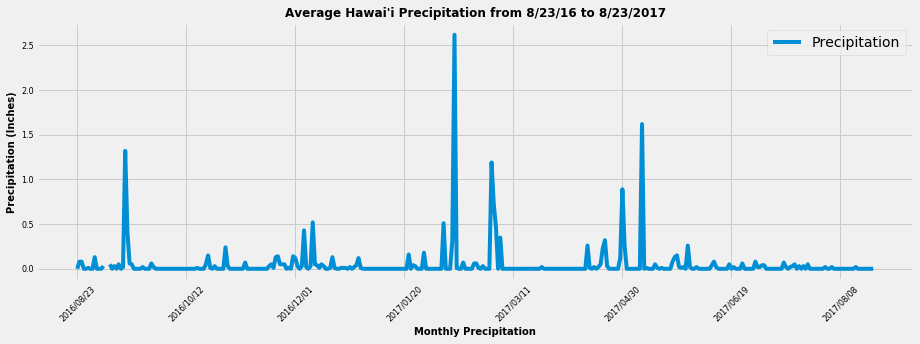

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results (continued from above)
df = pd.DataFrame(twelve_months, columns=['Date', 'Precipitation'])

# df.set_index('Date', inplace=True)
# df.dropna(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
months = df.groupby(df['Date'].dt.strftime('%Y/%m/%d'))['Precipitation'].mean()

months.plot(rot=45, figsize=(13,5))
plt.title("Average Hawai'i Precipitation from 8/23/16 to 8/23/2017", fontweight='bold', size=12)
plt.ylabel('Precipitation (Inches)',fontweight='bold', size=10)
plt.xlabel('Monthly Precipitation',fontweight='bold', size=10)
plt.yticks(size=8)
plt.xticks(size=8)
plt.tight_layout()
plt.legend()
plt.show()



In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
months.describe()

count    364.000000
mean       0.048709
std        0.204930
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        2.620000
Name: Precipitation, dtype: float64

In [16]:
# joined_data = [measure.station, measure.date, measure.prcp, measure.tobs, stn.station, stn.name, stn.latitude, stn.longitude, stn.elevation]
# data = session.query(*joined_data).filter(measure.station == stn.station).all()
    

In [17]:
# Get list of column names and types for station table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
# Design a query to show how many stations are available in this dataset?
stn_distinct = session.query(func.distinct(measure.station), func.count(measure.station)).\
            group_by(measure.station).\
            order_by(func.count(measure.station).desc()).all()
stn_distinct

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(func.distinct(measure.station), func.count(measure.station)).\
            group_by(measure.station).\
            order_by(func.count(measure.station).desc()).limit(1).scalar()
most_active
print(f'The most active station is {most_active}')

The most active station is USC00519281


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

data = [stn.station,
        stn.name,
        func.min(measure.tobs),
        func.max(measure.tobs),
        func.avg(measure.tobs)]
temps = session.query(*data).\
        filter(measure.station == stn.station).filter(measure.station == most_active).all()
average = "{0:.1f}".format(temps[0][4])

print(f"  Most active station\n ---------------------- \n ID: {temps[0][0]} \n Name: {temps[0][1]}\n\
 Lowest recorded temp: {temps[0][2]}\n Highest recorded temp: {temps[0][3]}\n Average temperature: {average}")

  Most active station
 ---------------------- 
 ID: USC00519281 
 Name: WAIHEE 837.5, HI US
 Lowest recorded temp: 54.0
 Highest recorded temp: 85.0
 Average temperature: 71.7


In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_date = session.query(measure.date).\
    filter(measure.station == most_active).\
    filter(func.strftime("%Y/%m/%d", measure.date)).\
    order_by(measure.date.desc()).first()
print(f"The most recent temperature for {most_active} was recorded on {last_date}")

one_year_ago = dt.date(2017, 8, 18) + relativedelta(years=-1)
print(f'Twelve months ago falls on the following date: {one_year_ago}')

temps_data = [measure.date,
       measure.tobs]
temps = session.query(*temps_data).filter(measure.station == most_active).\
    filter(func.strftime("%Y/%m/%d", measure.date) >= one_year_ago).\
    order_by(measure.date.asc()).all()
temps

# filter(measure.station == most_active).\


The most recent temperature for USC00519281 was recorded on ('2017-08-18',)
Twelve months ago falls on the following date: 2016-08-18


[('2016-01-01', 74.0),
 ('2016-01-02', 72.0),
 ('2016-01-03', 68.0),
 ('2016-01-04', 69.0),
 ('2016-01-05', 70.0),
 ('2016-01-06', 69.0),
 ('2016-01-07', 76.0),
 ('2016-01-08', 75.0),
 ('2016-01-09', 74.0),
 ('2016-01-10', 74.0),
 ('2016-01-11', 73.0),
 ('2016-01-12', 75.0),
 ('2016-01-13', 74.0),
 ('2016-01-14', 66.0),
 ('2016-01-15', 71.0),
 ('2016-01-16', 73.0),
 ('2016-01-17', 75.0),
 ('2016-01-18', 63.0),
 ('2016-01-19', 61.0),
 ('2016-01-20', 62.0),
 ('2016-01-21', 65.0),
 ('2016-01-22', 65.0),
 ('2016-01-23', 75.0),
 ('2016-01-24', 78.0),
 ('2016-01-25', 69.0),
 ('2016-01-26', 65.0),
 ('2016-01-27', 69.0),
 ('2016-01-28', 64.0),
 ('2016-01-29', 68.0),
 ('2016-01-30', 73.0),
 ('2016-01-31', 74.0),
 ('2016-02-01', 69.0),
 ('2016-02-02', 68.0),
 ('2016-02-03', 69.0),
 ('2016-02-04', 65.0),
 ('2016-02-05', 67.0),
 ('2016-02-06', 69.0),
 ('2016-02-07', 70.0),
 ('2016-02-08', 56.0),
 ('2016-02-09', 57.0),
 ('2016-02-10', 58.0),
 ('2016-02-11', 61.0),
 ('2016-02-12', 71.0),
 ('2016-02-

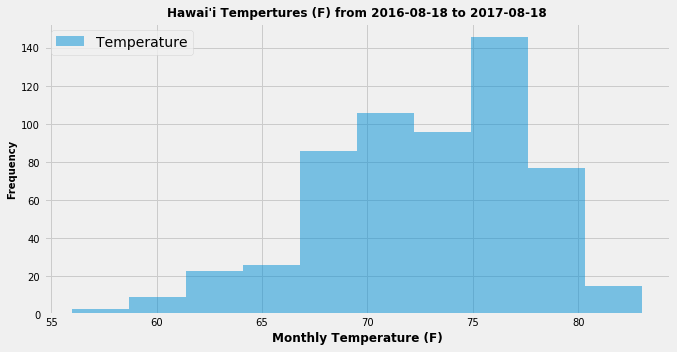

In [61]:
temps_df = pd.DataFrame(temps, columns=['Date','Temperature'])
temps_df.set_index('Date', inplace=True)
temps_df.dropna(inplace=True)
temps_df.plot.hist(figsize=(10,5), alpha=.5)
plt.title(f"Hawai'i Tempertures (F) from {one_year_ago} to 2017-08-18", fontweight='bold', size=12)
plt.ylabel ('Frequency',fontweight='bold', size=10)
plt.xlabel(f'Monthly Temperature (F)', size=12, fontweight='bold')
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
